[Link to the notebook](https://drive.google.com/file/d/1VY6n9Q1KKSbRrAVJ-4CQrH3oXrcRcm_Z/view?usp=sharing)

In [14]:
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import image
from matplotlib import pyplot
import os, sys
from PIL import Image
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
metadata = pd.read_csv("/content/drive/MyDrive/DATA/ISIC_2019_Training_Metadata.csv")
metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


In [6]:
df = pd.read_csv("/content/drive/MyDrive/DATA/ISIC_2019_Training_GroundTruth.csv")
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing the .csv file to get the target labels

In [7]:
del df['image']

In [8]:
skincancers = list(df)
print('Types of skin cancers:')
print(skincancers)

Types of skin cancers:
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


In [11]:
dflist = np.array(df.values.tolist())
print(dflist.shape)

(25331, 9)


In [12]:
label = np.argmax(dflist, axis=1)
print(len(label))

25331


## Reading the images

In [15]:
# Open the image form working directory
FOLDER_PATH = '/content/drive/MyDrive/DATA/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'

In [16]:
folder = FOLDER_PATH

images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("We have overall {} images".format(len(images)))



We have overall 25331 images


## Used a smaller dataset
##### Because of the slow reading

In [17]:
small_ds = images[:1000]
print(len(small_ds))

1000


In [18]:
import matplotlib.pyplot as plt

x = np.asarray([np.asarray(Image.open(folder+'/'+fname)) for fname in small_ds])
print(x.shape)


(1000, 1024, 1024, 3)


### Trying out on an example:

1
NV


<function matplotlib.pyplot.show>

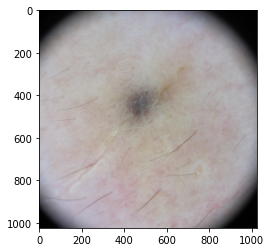

In [19]:
example_img_num = 677

print(label[example_img_num])
print(skincancers[label[example_img_num]])


plt.imshow(x[example_img_num])
plt.show

#### Train - Vaildation - Test split:

In [21]:
def split_data(X, Y, v_ratio=0.2, t_ratio=0.1):
  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:v_split],       Y[0:v_split]
  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [22]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(x, label)

print("Train: {} samples".format(len(X_train)))
print("Validation: {} samples".format(len(X_valid)))
print("Test: {} samples".format(len(X_test)))

Train: 700 samples
Validation: 200 samples
Test: 100 samples
